<a href="https://colab.research.google.com/github/chakma21/BTP/blob/main/Exploringlib/generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U sentence-transformers pandas openpyxl
# !pip install scikit-learn pandas numpy openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

Saving HW_keybert_keywords.csv to HW_keybert_keywords (1).csv
Sample of keywords: ['york accuses weinstein', 'harvey weinsteins alleged', 'harvey weinstein allegations', 'weinsteins alleged sexual', 'accusations rape weinstein', 'accuses weinstein raping', 'accuses harvey weinsteins', 'weinstein charged rape', 'harvey weinstein accused', 'allegations harvey weinstein']


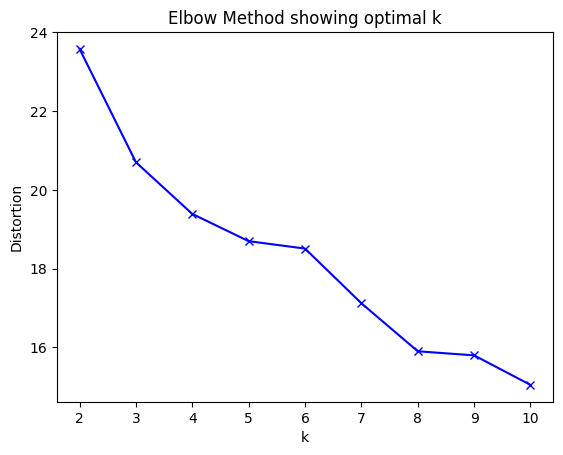


Cluster 'weinsteins alleged misconduct':
Contains 9 items.
['weinstein sexual misconduct', 'weinsteins alleged behaviour', 'harvey weinstein misconduct', 'weinsteins alleged misconduct', 'misconduct harvey weinstein', 'sues weinstein alleged', 'weinstein accusers record', 'police investigating weinstein', 'weinstein misconduct']

Cluster 'harvey weinstein sexual':
Contains 9 items.
['assaulted harvey weinstein', 'harvey weinstein raped', 'harvey weinstein assault', 'raped harvey weinstein', 'yorker weinstein sexually', 'assaults harvey weinstein', 'harvey weinstein sexual', 'harassment harvey weinstein', 'harvey weinstein inappropriate']

Cluster 'weinstein allegations':
Contains 45 items.
['york accuses weinstein', 'weinsteins alleged sexual', 'accusations rape weinstein', 'accuses weinstein raping', 'new allegations weinstein', 'weinstein alleged sexual', 'weinstein allegations', 'sexual allegations weinstein', 'weinstein following allegations', 'allegations weinstein new', 'weinste

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

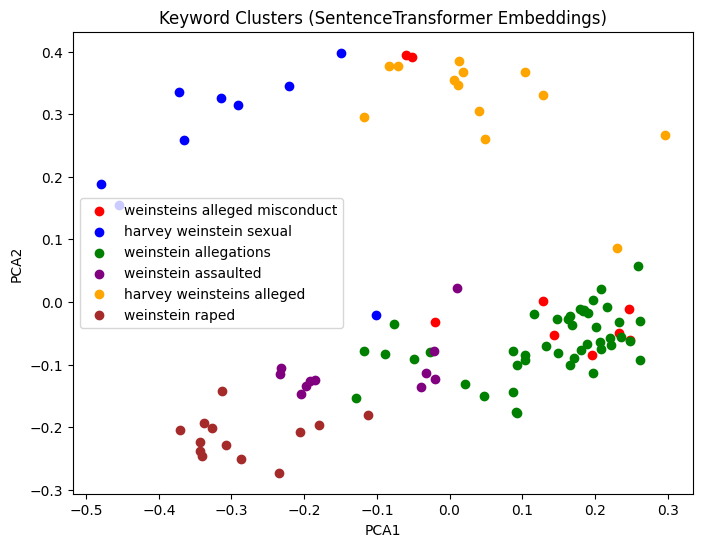

In [4]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import io

# Step 1: Upload your CSV (should have two columns: score,keyword)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Read the file and extract keywords
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    keyword_col = [col for col in df.columns if 'keyword' in col.lower()]
    if keyword_col:
        keywords = df[keyword_col[0]].astype(str).tolist()
    else:
        keywords = df.iloc[:,1].astype(str).tolist()
except Exception:
    lines = io.StringIO(uploaded[filename].decode('utf-8')).read().splitlines()
    keywords = [line.split(',')[1] for line in lines if ',' in line]

keywords = [k.strip() for k in keywords if k.strip()]
print("Sample of keywords:", keywords[:10])

# Step 3: Use SentenceTransformer to get embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(keywords)

# Step 4: Elbow method to find best k
def plot_elbow(X, max_k=10):
    distortions = []
    K = range(2, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method showing optimal k')
    plt.show()

plot_elbow(X, max_k=10)

# Step 5: Choose k
k = 6  # adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

# Step 6: Assign labels and representative names
clustered = pd.DataFrame({'Keyword': keywords, 'Cluster': labels})
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
cluster_names = [keywords[idx] for idx in closest]
clustered['Cluster Name'] = clustered['Cluster'].map(lambda x: cluster_names[x])

# Step 7: Print clusters
for i, name in enumerate(cluster_names):
    print(f"\nCluster '{name}':")
    cluster_items = clustered[clustered['Cluster']==i]['Keyword'].tolist()
    print(f"Contains {len(cluster_items)} items.")
    print(cluster_items)

# Step 8: Save results
excel_filename = "clustered_keywords_sentenceBERT.xlsx"
clustered.to_excel(excel_filename, index=False)
files.download(excel_filename)

# Step 9: Optional PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, name in enumerate(cluster_names):
    idxs = clustered['Cluster'] == i
    plt.scatter(X_pca[idxs,0], X_pca[idxs,1], c=colors[i%len(colors)], label=name)
plt.legend()
plt.title('Keyword Clusters (SentenceTransformer Embeddings)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()
